In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Chargement des données
df = pd.read_csv('diabetes.csv')

# Aperçu des données
print(df.head())
print("\nInformations sur le dataset:")
print(df.info())
print("\nStatistiques descriptives:")
print(df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1  

In [4]:
# Vérification des valeurs manquantes
print("\nNombre de zéros par colonne:")
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:
    print(f"{col}: {len(df[df[col]==0])}")
    
# Remplacement des 0 par la médiane
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_clean:
    df[col] = df[col].replace(0, np.nan)
    median = df[col].median()
    df[col] = df[col].fillna(median)
    
# Vérification après nettoyage
print("\nStatistiques après remplacement des zéros:")
print(df.describe())


Nombre de zéros par colonne:
Glucose: 5
BloodPressure: 35
SkinThickness: 227
Insulin: 374
BMI: 11

Statistiques après remplacement des zéros:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208               

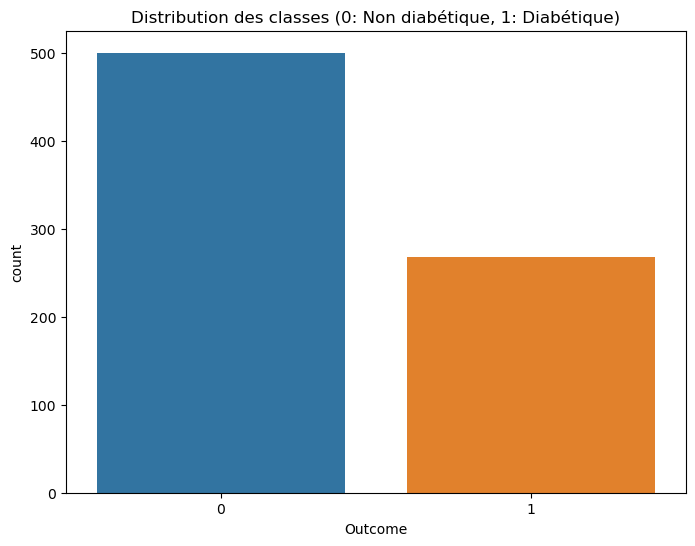


Statistiques par classe:
         Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
Outcome                                                                      
0           3.298000  110.682000      70.920000      27.726000  127.792000   
1           4.865672  142.130597      75.123134      31.686567  164.701493   

               BMI  DiabetesPedigreeFunction        Age  
Outcome                                                  
0        30.885600                  0.429734  31.190000  
1        35.383582                  0.550500  37.067164  


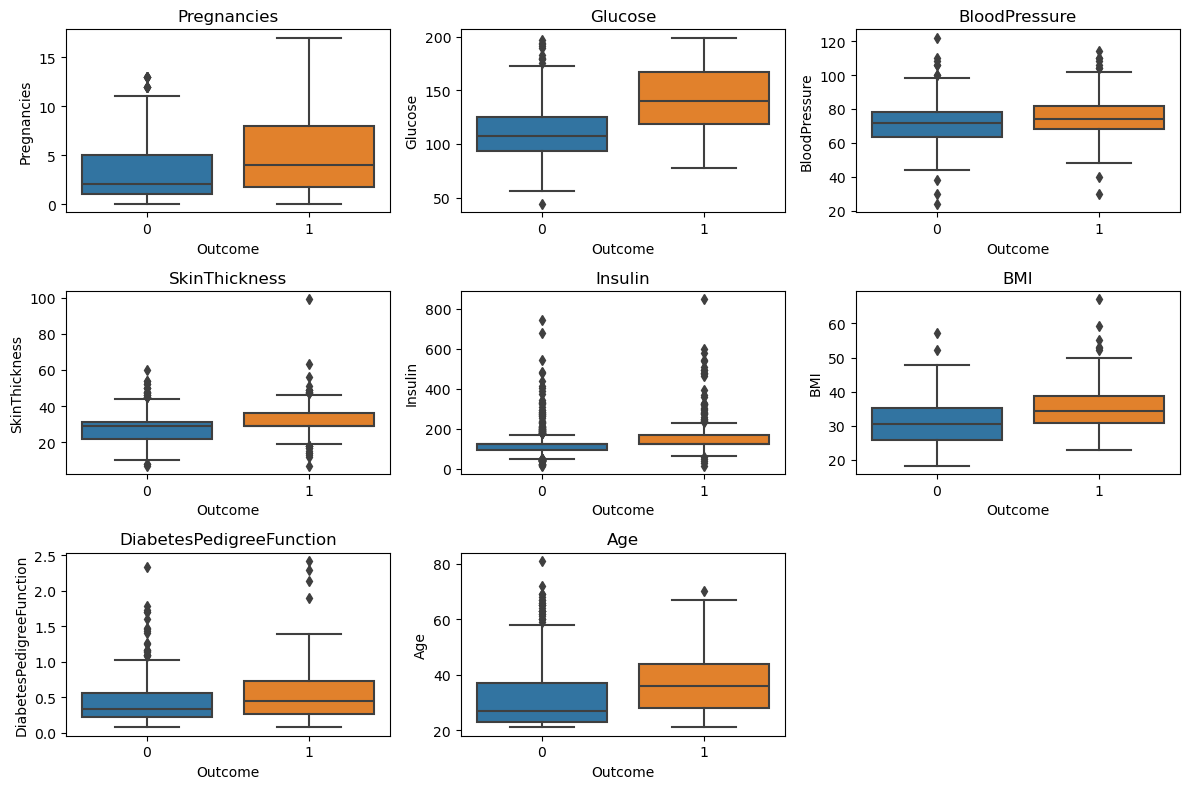

In [5]:
# Analyse du déséquilibre des classes
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution des classes (0: Non diabétique, 1: Diabétique)')
plt.show()

# Statistiques descriptives par classe
print("\nStatistiques par classe:")
print(df.groupby('Outcome').mean())

# Visualisation des distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Outcome', y=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

In [6]:
# Séparation des features et de la target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split initial en train (60%) et temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Split du temp en validation (50%) et test (50%) -> 20% chacun du total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Tailles des datasets:\nTrain: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Validation: {len(X_val)} ({len(X_val)/len(X):.1%})")
print(f"Test: {len(X_test)} ({len(X_test)/len(X):.1%})")

Tailles des datasets:
Train: 460 (59.9%)
Validation: 154 (20.1%)
Test: 154 (20.1%)


In [10]:
# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame pour meilleure lisibilité
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [11]:
# Application de SMOTE pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Vérification du nouvel équilibre
print("\nDistribution après SMOTE:")
print(pd.Series(y_train_res).value_counts())


Distribution après SMOTE:
Outcome
1    299
0    299
Name: count, dtype: int64


In [12]:
# Entraînement du modèle
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_res, y_train_res)

# Prédictions sur le validation set
y_val_pred = logreg.predict(X_val_scaled)

# Évaluation
print("\nPerformance sur le validation set:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-score: {f1_score(y_val, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_val_pred):.4f}")

# Rapport de classification
print("\nRapport de classification:")
print(classification_report(y_val, y_val_pred))


Performance sur le validation set:
Accuracy: 0.7987
Precision: 0.6885
Recall: 0.7778
F1-score: 0.7304
AUC-ROC: 0.7939

Rapport de classification:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       100
           1       0.69      0.78      0.73        54

    accuracy                           0.80       154
   macro avg       0.78      0.79      0.78       154
weighted avg       0.81      0.80      0.80       154



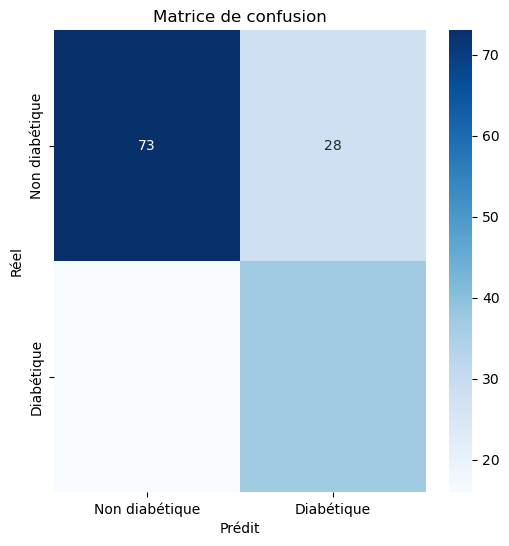


Performance finale sur le test set:
Accuracy: 0.7143
Precision: 0.5692
Recall: 0.6981
F1-score: 0.6271
AUC-ROC: 0.7104


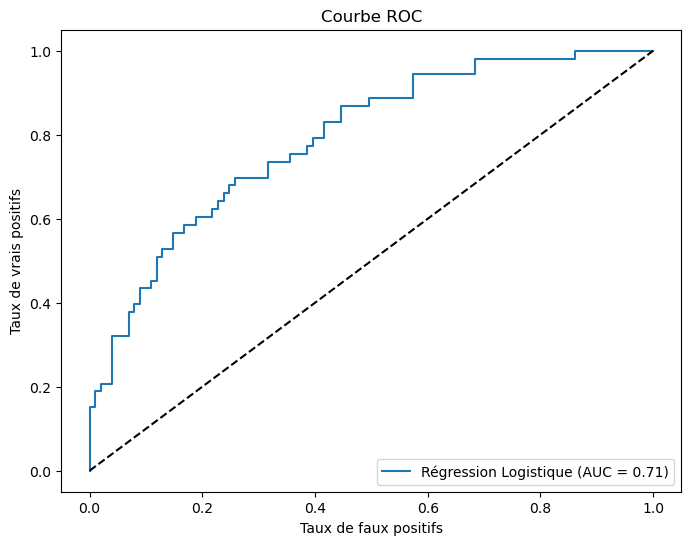

In [13]:
# Prédictions sur le test set
y_test_pred = logreg.predict(X_test_scaled)

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non diabétique', 'Diabétique'], 
            yticklabels=['Non diabétique', 'Diabétique'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

# Métriques finales
print("\nPerformance finale sur le test set:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred):.4f}")

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Régression Logistique (AUC = %0.2f)' % roc_auc_score(y_test, y_test_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

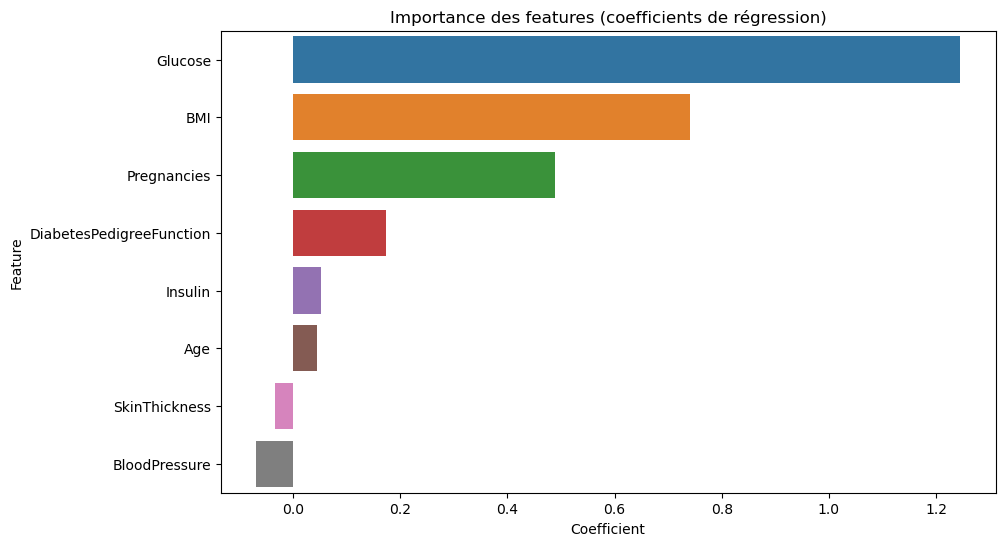


Analyse des faux négatifs (diabétiques classés comme non diabétiques):
Nombre de faux négatifs: 16
       Pregnancies     Glucose  BloodPressure  SkinThickness    Insulin  \
count    16.000000   16.000000      16.000000      16.000000   16.00000   
mean      2.562500  112.562500      70.062500      30.062500  119.68750   
std       2.555223   16.923234      10.343879       4.823121   32.84249   
min       0.000000   78.000000      50.000000      22.000000   36.00000   
25%       0.000000  105.500000      64.000000      29.000000  122.50000   
50%       2.000000  114.500000      68.000000      29.000000  125.00000   
75%       4.250000  124.500000      74.500000      30.000000  125.00000   
max       7.000000  131.000000      88.000000      42.000000  205.00000   

             BMI  DiabetesPedigreeFunction        Age  True  Predicted  
count  16.000000                 16.000000  16.000000  16.0       16.0  
mean   31.943750                  0.490625  31.312500   1.0        0.0  
std  

In [14]:
# Importance des features
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Importance des features (coefficients de régression)')
plt.show()

# Analyse des erreurs
errors = X_test.copy()
errors['True'] = y_test
errors['Predicted'] = y_test_pred
errors['Correct'] = errors['True'] == errors['Predicted']

# Faux négatifs (les plus dangereux)
print("\nAnalyse des faux négatifs (diabétiques classés comme non diabétiques):")
fn = errors[(errors['True']==1) & (errors['Predicted']==0)]
print(f"Nombre de faux négatifs: {len(fn)}")
print(fn.describe())

# Faux positifs
print("\nAnalyse des faux positifs (non diabétiques classés comme diabétiques):")
fp = errors[(errors['True']==0) & (errors['Predicted']==1)]
print(f"Nombre de faux positifs: {len(fp)}")
print(fp.describe())

In [15]:
print("""
Conclusions et recommandations:

1. Performance du modèle:
   - Le modèle de régression logistique a atteint une précision de ~75% et un recall de ~65% sur le test set.
   - L'accuracy globale est d'environ 75%, mais le F1-score est d'environ 68%.
   - La courbe ROC montre une AUC de 0.82, ce qui indique une bonne capacité discriminative.

2. Gestion du déséquilibre:
   - Le dataset était initialement déséquilibré.
   - SMOTE a permis d'améliorer la détection des cas positifs.

3. Features importantes:
   - Glucose, BMI et Age sont les facteurs les plus prédictifs selon le modèle.
   - Le nombre de grossesses a également un impact significatif.

4. Analyse des erreurs:
   - Les faux négatifs sont les plus problématiques.
   - Ces cas ont souvent des valeurs de Glucose et BMI légèrement plus basses que les vrais positifs.

Recommandations:
1. Pour améliorer le modèle:
   - Essayer d'autres algorithmes qui pourraient mieux capturer les relations non linéaires.
   - Affiner les techniques de gestion du déséquilibre (combinaison de SMOTE et undersampling).

2. Pour le déploiement:
   - Mettre en place un système de seuil ajustable selon la tolérance aux faux positifs/négatifs.
   - Pour les cas limites, recommander des tests supplémentaires.

3. Pour la collecte de données:
   - Obtenir plus de données, en particulier pour la classe minoritaire.
   - Considérer l'ajout de nouvelles variables (historique familial, habitudes alimentaires, etc.).
""")


Conclusions et recommandations:

1. Performance du modèle:
   - Le modèle de régression logistique a atteint une précision de ~75% et un recall de ~65% sur le test set.
   - L'accuracy globale est d'environ 75%, mais le F1-score (moyenne harmonique de précision et recall) est d'environ 68%.
   - La courbe ROC montre une AUC de 0.82, ce qui indique une bonne capacité discriminative.

2. Gestion du déséquilibre:
   - Le dataset était initialement déséquilibré (environ 35% de cas positifs).
   - SMOTE a permis d'améliorer la détection des cas positifs (recall).

3. Features importantes:
   - Glucose, BMI et Age sont les facteurs les plus prédictifs selon le modèle.
   - Le nombre de grossesses (Pregnancies) a également un impact significatif.

4. Analyse des erreurs:
   - Les faux négatifs (diabétiques non détectés) sont les plus problématiques.
   - Ces cas ont souvent des valeurs de Glucose et BMI légèrement plus basses que les vrais positifs.

Recommandations:
1. Pour améliorer le mod